<a href="https://colab.research.google.com/github/honi-sm/AmphiBIO_TraitAnalysisFinal/blob/main/02InferentialAnalysisFinalPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Inferential Stats: Execution
# Purpose = Performs inferential analyses on log10 var 500 sample cleaned dataset.

# This notebook assumes `ds = AmphiBIODataset...load()` produces `df = ds.df`.

# Rules for Later Me
# Do not rename columns, recode categories, or create new categories here.
# If a change to data prep is needed, go to the cleaning notebook.
# All hypothesis tests must report: effect size + confidence info, multiple testing handling when relevant.
# Any descriptive stats belongs in the descriptive notebook, not here.

In [5]:
#git dat shit (getting from github repo)
!git clone https://github.com/honi-sm/AmphiBIO_TraitAnalysisFinal.git

import os
os.chdir("/content/AmphiBIO_TraitAnalysisFinal")

Cloning into 'AmphiBIO_TraitAnalysisFinal'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 106 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (106/106), 2.77 MiB | 10.13 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [6]:
#IMPORTS AND INFR. STAT PREP

# System
import os, sys, time, warnings
from dataclasses import dataclass
from typing import Optional

warnings.filterwarnings("ignore")

# The usuals
import numpy as np
import pandas as pd

# Seed from earlier (same 500 sample)
SEED = 2025
np.random.seed(SEED)

# Stats needed
import scipy
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.diagnostic import het_breuschpagan

from statsmodels.stats.multitest import multipletests

# Post hoc tests
!pip -q install scikit-posthocs pingouin
import scikit_posthocs as sp
import pingouin as pg

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# PCA
from sklearn.decomposition import PCA
!pip -q install umap-learn
import umap

# ML
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Versions used (to cite in paper)
import sklearn

print("Python:", sys.version.split()[0])
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("statsmodels:", sm.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sklearn.__version__)
print("umap-learn:", umap.__version__)
print("pingouin:", pg.__version__)
print("scikit-posthocs:", sp.__version__)
print("SEED =", SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.6 MB/s eta 0:00:00
Python: 3.12.12
numpy: 2.0.2
pandas: 2.2.2
scipy: 1.16.3
statsmodels: 0.14.6
seaborn: 0.13.2
sklearn: 1.6.1
umap-learn: 0.5.9.post2
pingouin: 0.5.5
scikit-posthocs: 0.11.4
SEED = 2025


In [7]:
for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if "sample500" in name:
            print(os.path.join(root, name))

./Data/Processed/sample500_with_logs (1).csv


In [8]:
"""
AmphiBIO Inferential Analysis
Author: Lia Grace Stratos
Institution: University of Nebraska Omaha
Date: December 9 2025

Purpose:
Run the inferential stata on the cleaned, log10-transformed
500-species AmphiBIO sample (seed = 2025). Tests whether the
amphibian traits differ across reproductive modes, whether habitat and
reproductive mode are associated, and how strongly continuous traits
relate to each other (w/ effect sizes).

Inputs:
- Cleaned dataset: 500-species random sample (seed = 2025)
- randomsample500 csv thing
- Continuous traits (log10):
    * logBodyLengthMm
    * logClutchSizeMinN
    * logClutchSizeMaxN
- Categorical predictors:
    * reproductiveMethod (direct / larval / viviparous)
    * habitatClass (expanded rom habitatType; aquatic-associated / aquatic-only
    / arboreal-only / generalist / terrestrial-associated / terrestrial-only / other)

Research Questions:
1) Do amphibian body lengths differ across reproductive modes?
    - H0.1: There is NO difference in mean log-trans body length or clutch size
    among amphibian reproductive modes
    - H1.1: @ least one reproductive mode differs in mean log-trans body size or
    clutch size.

2) Do clutch sizes (min/max) differ across reproductive modes?
    - H0.2: Habitat class and reproductive strategy are indep. Distribution does NOT
    difer across habitat classes
    - H1.2: Habiat class andreproductive method are NOT INDP., reproductive modes
    are unevenl distributed across habitat classes

3) Are habitat category and reproductive method statistically associated?
    - H0.3: There is no stat association between log-trans body size + clutch size
    - H1.3: There IS a  stat association between log-trans body size + clutch size

4) How strongly are continuous traits related (body size vs clutch size)?
    - H0.4: W/ habitat class or distrib. skew, body size does NOT predict clutch size
    - H1.4: Body size is a significant predictor of clutch size across models.

5) Does body length predict clutch size?
    - H0.5: There is not sufficient data to say body length predicts clutch size
    - H1.5: It does!

Biology Background Expected/Research:
- Based on general amphibian life-history patterns and AmphiBIO (Oliveira et al., 2017):
!Direct! developers often show lower clutch sizes relative to larval strategies.
! Body size and clutch size typically scale positively, but with wide variation.
! Habitat and reproduction may align in some ecologies (not perfectly tho).

Methods in here:
A) Group comparisons across reproductiveMethod
   - Welch ANOVA (does not assume equal variances)
   - Games–Howell post hoc tests (pairwise comparisons under unequal variances)
   - Effect sizes reported (eta-squared / omega-squared; pairwise standardized
     mean differences where calculated)

B) Association between habitatClass and reproductiveMethod
   - Chi-square test of independence
   - Effect size: Cramer's V

C) Continuous relationships
   - Spearman correlations (nonparametric): rho (ρ)
   - Simple linear regression: logClutchSizeMaxN ~ logBodyLengthMm
     * report R² and robust SE (HC3) w/ heteroskedasticity

Assumptions:
- Log10 transforms were applied to reduce right-skew
- Welch ANOVA + Games–Howell are used because variance equality is not assumed
- Spearman correlation is used because relationships may be monotonic but non-linear
- Regression diagnostics are checked; robust SEs used

Outputs:
- Summary tables for Welch ANOVA + effect sizes
- Games–Howell p-value matrices / heatmaps
- Chi-square table + Cramer's V
- Spearman correlation table
- Regression summary + diagnostic plots
"""

"\nAmphiBIO Inferential Analysis\nAuthor: Lia Grace Stratos\nInstitution: University of Nebraska Omaha\nDate: December 9 2025\n\nPurpose:\nRun the inferential stata on the cleaned, log10-transformed\n500-species AmphiBIO sample (seed = 2025). Tests whether the\namphibian traits differ across reproductive modes, whether habitat and\nreproductive mode are associated, and how strongly continuous traits\nrelate to each other (w/ effect sizes).\n\nInputs:\n- Cleaned dataset: 500-species random sample (seed = 2025)\n- randomsample500 csv thing\n- Continuous traits (log10):\n    * logBodyLengthMm\n    * logClutchSizeMinN\n    * logClutchSizeMaxN\n- Categorical predictors:\n    * reproductiveMethod (direct / larval / viviparous)\n    * habitatClass (expanded rom habitatType; aquatic-associated / aquatic-only\n    / arboreal-only / generalist / terrestrial-associated / terrestrial-only / other)\n\nResearch Questions:\n1) Do amphibian body lengths differ across reproductive modes?\n    - H0.1: T

In [9]:
# LIBRARY SETUP

from dataclasses import dataclass
from typing import Callable, Optional, List, Dict, Any
import numpy as np
import pandas as pd

@dataclass(frozen=True)
class ColumnSpec:
    name: str
    dtype: str
    description: str
    allowed: Optional[List[str]] = None
    source: Optional[str] = None     # where it comes from if raw or I made
    transform: Optional[str] = None  # how it is computed
    usedIn: Optional[List[str]] = None

# Columns Specifics
columnSpecs: Dict[str, ColumnSpec] = {
    "Species": ColumnSpec(
        name="Species",
        dtype="string",
        description="Species scientific name (unique ID)",
        source="input",
        usedIn=["group summaries", "QA"]
    ),

    "habitatType": ColumnSpec(
        name="habitatType",
        dtype="string",
        description="Raw habitat composite label (contains '+' for combos)",
        source="input",
        usedIn=["traitMaking(habitatClass)"]
    ),

    "habitatClass": ColumnSpec(
        name="habitatClass",
        dtype="category",
        description="Habitat category collapsed from habitatType (concise)",
        source="made",
        transform="classifyHabitat(habitatType)",
        allowed=[
            "aquatic-only", "aquatic-associated",
            "arboreal-only", "arboreal-associated",
            "terrestrial-only", "terrestrial-associated",
            "generalist", "other"
        ],
        usedIn=["chiSquare(habitatClass x reproductiveMethod)", "multRegression"]
    ),

    "reproductiveMethod": ColumnSpec(
        name="reproductiveMethod",
        dtype="category",
        description="Reproductive mode category",
        source="input or made",
        allowed=["direct", "larval", "viviparous"],
        usedIn=["welchAnova", "gamesHowell", "multRegression", "group summaries"]
    ),

    "bodyLengthMm": ColumnSpec(
        name="bodyLengthMm",
        dtype="numeric",
        description="Body length in millimeters (raw scale)",
        source="input",
        usedIn=["QA", "GLM"]
    ),

    "clutchSizeMinN": ColumnSpec(
        name="clutchSizeMinN",
        dtype="numeric",
        description="Minimum clutch size (count)",
        source="input",
        usedIn=["QA", "GLM"]
    ),

    "clutchSizeMaxN": ColumnSpec(
        name="clutchSizeMaxN",
        dtype="numeric",
        description="Maximum clutch size (count)",
        source="input",
        usedIn=["QA", "GLM"]
    ),

    "logBodyLengthMm": ColumnSpec(
        name="logBodyLengthMm",
        dtype="numeric",
        description="log10(bodyLengthMm)",
        source="made or input",
        transform="log10(bodyLengthMm)",
        usedIn=["spearman", "regression", "PCA/UMAP"]
    ),

    "logClutchSizeMinN": ColumnSpec(
        name="logClutchSizeMinN",
        dtype="numeric",
        description="log10(clutchSizeMinN)",
        source="made or input",
        transform="log10(clutchSizeMinN)",
        usedIn=["welchAnova", "spearman", "PCA/UMAP"]
    ),

    "logClutchSizeMaxN": ColumnSpec(
        name="logClutchSizeMaxN",
        dtype="numeric",
        description="log10(clutchSizeMaxN)",
        source="made or input",
        transform="log10(clutchSizeMaxN)",
        usedIn=["welchAnova", "spearman", "regression", "PCA/UMAP"]
    ),
}

# Double checking names are the same across notebook/tranform : Aliases to standardized
columnAliases: Dict[str, str] = {
    "log_bodyLengthMm": "logBodyLengthMm",
    "log_clutchSizeMinN": "logClutchSizeMinN",
    "log_clutchSizeMaxN": "logClutchSizeMaxN",
    "HabitatClass": "habitatClass",
    "HabitatType": "habitatType",
    "ReproductiveMethod": "reproductiveMethod",
}

def classifyHabitat(h):
    if pd.isna(h):
        return "other"

    parts = [p.strip().lower() for p in str(h).split("+") if p.strip()]
    n = len(parts)

    hasT  = "terrestrial" in parts
    hasAq = "aquatic" in parts
    hasAr = "arboreal" in parts
    hasFo = "fossorial" in parts

    if n >= 3:
        return "generalist"
    if n == 1 and hasAq:
        return "aquatic-only"
    if hasAq and n == 2:
        return "aquatic-associated"
    if n == 1 and hasT:
        return "terrestrial-only"
    if hasT and n == 2:
        return "terrestrial-associated"
    if n == 1 and hasAr:
        return "arboreal-only"
    if hasAr and n == 2 and not hasAq and not hasT:
        return "arboreal-associated"
    return "other"


def addHabitatClass(df, source_col="habitatType", out_col="habitatClass"):
    if source_col not in df.columns:
        raise KeyError(f"{source_col} column missing {out_col}.")
    df = df.copy()
    df[out_col] = df[source_col].apply(classifyHabitat).astype("string")
    return df
def showDataLibrary() -> pd.DataFrame:
    """Return preddy summ"""
    rows = []
    for spec in columnSpecs.values():
        rows.append({
            "column": spec.name,
            "dtype": spec.dtype,
            "description": spec.description,
            "allowed": ", ".join(spec.allowed) if spec.allowed else "",
            "source": spec.source or "",
            "transform": spec.transform or "",
            "usedIn": ", ".join(spec.usedIn) if spec.usedIn else "",
        })
    return pd.DataFrame(rows)

def standardizeColumnNames(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize aliases"""
    return df.rename(columns={k: v for k, v in columnAliases.items() if k in df.columns})

def normalizeCategoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Lowercase/strip categoricals"""
    for col in ["reproductiveMethod", "habitatType", "habitatClass"]:
        if col in df.columns:
            df[col] = df[col].astype("string").str.strip().str.lower()
    return df

def validateSchema(df: pd.DataFrame, strict: bool = True) -> Dict[str, Any]:
    """
    Presence, dtype, and allowed categories
    strict=True raises errors; strict=False returns issues in plain txt
    """
    issues = {"missing": [], "badType": [], "badValues": []}

    for name, spec in columnSpecs.items():
        if name not in df.columns:
            issues["missing"].append(name)
            continue

        if spec.dtype == "numeric":
            if not np.issubdtype(df[name].dtype, np.number):
                issues["badType"].append((name, str(df[name].dtype), "numeric"))
        elif spec.dtype in ("string", "category"):
            # allow object or pandas string dtype
            if str(df[name].dtype) not in ("string", "object", "category"):
                issues["badType"].append((name, str(df[name].dtype), spec.dtype))

        if spec.allowed and name in df.columns:
            observed = set(df[name].dropna().astype("string").str.lower().unique())
            allowed = set([a.lower() for a in spec.allowed])
            bad = sorted(list(observed - allowed))
            if bad:
                issues["badValues"].append((name, bad))

    if strict and (issues["missing"] or issues["badType"] or issues["badValues"]):
        msg = ["SCHEMA VALIDATION FAILED"]
        if issues["missing"]:
            msg.append(f"Missing: {issues['missing']}")
        if issues["badType"]:
            msg.append(f"Bad dtypes: {issues['badType']}")
        if issues["badValues"]:
            msg.append(f"Bad categorical values: {issues['badValues']}")
        raise ValueError("\n".join(msg))

    return issues

# Preddy colors for graphs
import seaborn as sns
import matplotlib.pyplot as plt

jewel = ["#6A5ACD", "#20B2AA", "#C77DFF", "#FF6B6B", "#4CC9F0"]
jewel_dark = ["#4B3FA6", "#1C8C7D", "#9F5ACC", "#CC5555", "#379AC2"]

# Preddy TO DO/Table of Contents
print("Sections:")
print("1) Check data")
print("2) HabitatClass concisety")
print("3) Welch ANOVA + Games–Howell")
print("4) Chi-square + Cramer's V")
print("5) Spearman correlations")
print("6) Regression Models")
print("7) Exports tables/figures")
display(showDataLibrary())

Sections:
1) Check data
2) HabitatClass concisety
3) Welch ANOVA + Games–Howell
4) Chi-square + Cramer's V
5) Spearman correlations
6) Regression Models
7) Exports tables/figures


,column,dtype,description,allowed,source,transform,usedIn
0,Species,string,Species scientific name (unique ID),,input,,"group summaries, QA"
1,habitatType,string,Raw habitat composite label (contains '+' for ...,,input,,traitMaking(habitatClass)
2,habitatClass,category,Habitat category collapsed from habitatType (c...,"aquatic-only, aquatic-associated, arboreal-onl...",made,classifyHabitat(habitatType),"chiSquare(habitatClass x reproductiveMethod), ..."
3,reproductiveMethod,category,Reproductive mode category,"direct, larval, viviparous",input or made,,"welchAnova, gamesHowell, multRegression, group..."
4,bodyLengthMm,numeric,Body length in millimeters (raw scale),,input,,"QA, GLM"
5,clutchSizeMinN,numeric,Minimum clutch size (count),,input,,"QA, GLM"
6,clutchSizeMaxN,numeric,Maximum clutch size (count),,input,,"QA, GLM"
7,logBodyLengthMm,numeric,log10(bodyLengthMm),,made or input,log10(bodyLengthMm),"spearman, regression, PCA/UMAP"
8,logClutchSizeMinN,numeric,log10(clutchSizeMinN),,made or input,log10(clutchSizeMinN),"welchAnova, spearman, PCA/UMAP"
9,logClutchSizeMaxN,numeric,log10(clutchSizeMaxN),,made or input,log10(clutchSizeMaxN),"welchAnova, spearman, regression, PCA/UMAP"


In [10]:
from typing import Optional
import pandas as pd

class DatasetBase:
    def __init__(self, dataPath: str):
        self.dataPath = dataPath
        self.df: Optional[pd.DataFrame] = None

    def load(self):
        self.df = pd.read_csv(self.dataPath)
        print(f"Loaded: {self.dataPath}")
        print(f"Shape: {self.df.shape}")
        return self


class AmphiBIODataset(DatasetBase):
    def prep(self, strict_schema: bool = False):
        """
        PREP:
        1) standardize names
        2) normalize categoricals
        3) make habitatClass
        4) double check
        """
        if self.df is None:
            raise RuntimeError("Call .load() before .prep().")

        # 1) standardize
        self.df = standardizeColumnNames(self.df)

        # 2) normalize
        self.df = normalizeCategoricals(self.df)

        # 3) make habitatclass
        if "habitatClass" not in self.df.columns:
            self.df = addHabitatClass(self.df)

        # 4) doublecheck
        issues = validateSchema(self.df, strict=strict_schema)

        print("Prep complete")
        if issues:
            print("Schema issues:", issues)

        return self

In [11]:
dataPath = "./Data/Processed/sample500_with_logs (1).csv"

ds = AmphiBIODataset(dataPath).load().prep(strict_schema=False)
df = ds.df

df["habitatClass"].value_counts(dropna=False)
df.head()

Loaded: ./Data/Processed/sample500_with_logs (1).csv
Shape: (500, 9)
Prep complete
Schema issues: {'missing': [], 'badType': [], 'badValues': []}


,Species,bodyLengthMm,clutchSizeMinN,clutchSizeMaxN,habitatType,reproductiveMethod,logBodyLengthMm,logClutchSizeMinN,logClutchSizeMaxN,habitatClass
0,atelopus cruciger,50.0,271.0,271.0,terrestrial + aquatic,larval,1.698970,2.432969,2.432969,aquatic-associated
1,limnonectes microdiscus,70.0,53.0,53.0,terrestrial + aquatic,larval,1.845098,1.724276,1.724276,aquatic-associated
2,hyla savignyi,49.0,200.0,1000.0,aquatic + arboreal,larval,1.690196,2.301030,3.000000,aquatic-associated
3,scinax littoralis,39.9,398.0,701.0,terrestrial + aquatic + arboreal,larval,1.600973,2.599883,2.845718,generalist
4,lithobates forreri,114.0,100.0,100.0,terrestrial + aquatic,larval,2.056905,2.000000,2.000000,aquatic-associated


In [12]:
assert "habitatClass" in df.columns
assert df["habitatClass"].isna().sum() == 0

In [13]:
# Inspect data from prepared: ds = AmphiBIODataset(dataPath).load().prep()
# ONLY inspects ds.df and does NOT modify it.

df = ds.df  # new from prep

print("After Prep")
print("Shape:", df.shape)

print("\nColumns:")
for c in df.columns:
    print(" -", c)

from IPython.display import display

# Random preview to check all over the 500 sample
display(df.sample(8, random_state=2025))

print("\nInfo:")
df.info()

print("\nNumeric summary:")
display(df.describe(include=[np.number]).T)

print("\nCategorical summary:")
display(df.describe(include=["string", "object", "category"]).T)

After Prep
Shape: (500, 10)

Columns:
 - Species
 - bodyLengthMm
 - clutchSizeMinN
 - clutchSizeMaxN
 - habitatType
 - reproductiveMethod
 - logBodyLengthMm
 - logClutchSizeMinN
 - logClutchSizeMaxN
 - habitatClass


,Species,bodyLengthMm,clutchSizeMinN,clutchSizeMaxN,habitatType,reproductiveMethod,logBodyLengthMm,logClutchSizeMinN,logClutchSizeMaxN,habitatClass
34,phyllobates aurotaenia,34.0,30.0,30.0,terrestrial + aquatic,larval,1.531479,1.477121,1.477121,aquatic-associated
400,calotriton asper,160.0,20.0,30.0,terrestrial + aquatic,larval,2.204120,1.301030,1.477121,aquatic-associated
239,hypsiboas crepitans,75.0,1064.0,2131.0,terrestrial + arboreal,larval,1.875061,3.026942,3.328583,terrestrial-associated
413,anotheca spinosa,80.0,48.0,317.0,terrestrial + aquatic + arboreal,larval,1.903090,1.681241,2.501059,generalist
65,hyperolius viridiflavus,34.0,12.0,650.0,terrestrial + arboreal,larval,1.531479,1.079181,2.812913,terrestrial-associated
422,ranitomeya amazonica,19.0,1.0,6.0,terrestrial + arboreal,larval,1.278754,0.000000,0.778151,terrestrial-associated
414,pipa aspera,45.0,12.0,26.0,fossorial + aquatic,direct,1.653213,1.079181,1.414973,aquatic-associated
182,pseudacris nigrita,32.0,59.0,800.0,fossorial + terrestrial + aquatic,larval,1.505150,1.770852,2.903090,generalist



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Species             500 non-null    object 
 1   bodyLengthMm        500 non-null    float64
 2   clutchSizeMinN      500 non-null    float64
 3   clutchSizeMaxN      500 non-null    float64
 4   habitatType         499 non-null    string 
 5   reproductiveMethod  500 non-null    string 
 6   logBodyLengthMm     500 non-null    float64
 7   logClutchSizeMinN   500 non-null    float64
 8   logClutchSizeMaxN   500 non-null    float64
 9   habitatClass        500 non-null    string 
dtypes: float64(6), object(1), string(3)
memory usage: 39.2+ KB

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
bodyLengthMm,500.0,73.727680,96.575137,13.300000,33.000000,50.000000,81.700000,1360.000000
clutchSizeMinN,500.0,588.756000,1679.104571,1.000000,20.000000,101.500000,300.000000,15000.000000
clutchSizeMaxN,500.0,1055.646000,2569.734362,1.000000,35.500000,217.500000,990.000000,25500.000000
logBodyLengthMm,500.0,1.738716,0.296750,1.123852,1.518514,1.698970,1.912221,3.133539
logClutchSizeMinN,500.0,1.959355,0.876823,0.000000,1.301030,2.006461,2.477121,4.176091
logClutchSizeMaxN,500.0,2.283959,0.870465,0.000000,1.550097,2.337458,2.995635,4.406540



Categorical summary:


,count,unique,top,freq
Species,500,500,philoria kundagungan,1
habitatType,499,11,terrestrial + aquatic,151
reproductiveMethod,500,3,larval,416
habitatClass,500,7,generalist,191


In [49]:
# Data Prep complete

# INFERENTIAL PLAN
# - Welch ANOVA + Games-Howell
# - Chi-square + Cramer's V
# - Spearman correlations
# - Regressions: OLS Simpl, OLS Multtivar, OLS-HC3
# - Exports all tables to /outputs

In [50]:
#Execute Welch ANOVA
"""
Evaluates mean differences in log-transformed reproductive traits
exist across categorical groups with for unequal variances and unbalanced sample sizes. A Welch one-way ANOVA is used in place of the classical
ANOVA due to violations of homoscedasticity known from assumption testing.
If Welch test is significant, pairwise group differences are examined
using the Games–Howell post, which matches assumptions

Outputs:
- Welch ANOVA F statistic, degrees of freedom, and p-value
- Games–Howell pairwise comparisons with adjusted p-values
- (Optional) effect size estimates for group differences
"""

import numpy as np, pandas as pd
from scipy import stats
import pingouin as pg

GROUP = "reproductiveMethod"
DV_LOGS = ["logBodyLengthMm", "logClutchSizeMinN", "logClutchSizeMaxN"]

df_inf = df.dropna(subset=[GROUP] + DV_LOGS).copy()

# Welch ANOVA
welch_table = pd.concat(
    [pg.welch_anova(dv=dv, between=GROUP, data=df_inf).assign(trait=dv)
     for dv in DV_LOGS],
    ignore_index=True
)

# Games–Howell posthoc
gh_table = pd.concat(
    [pg.pairwise_gameshowell(dv=dv, between=GROUP, data=df_inf).assign(trait=dv)
     for dv in DV_LOGS],
    ignore_index=True
)

display(welch_table)
display(gh_table)

,Source,ddof1,ddof2,F,p-unc,np2,trait
0,reproductiveMethod,2,2.644098,0.852665,0.517885,0.007131,logBodyLengthMm
1,reproductiveMethod,2,2.674627,97.146320,0.003185,0.205464,logClutchSizeMinN
2,reproductiveMethod,2,2.901045,151.268346,0.001165,0.263147,logClutchSizeMaxN


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,trait
0,direct,larval,1.691503,1.746934,-0.055432,0.039152,-1.415799,106.173013,3.364435e-01,-0.188299,logBodyLengthMm
1,direct,viviparous,1.691503,1.965067,-0.273564,0.623716,-0.438603,1.006904,9.083199e-01,-0.790151,logBodyLengthMm
2,larval,viviparous,1.746934,1.965067,-0.218132,0.622802,-0.350244,1.001016,9.385719e-01,-0.753314,logBodyLengthMm
3,direct,larval,1.083359,2.137596,-1.054238,0.068189,-15.460489,183.473484,0.000000e+00,-1.343877,logClutchSizeMinN
4,direct,viviparous,1.083359,0.801030,0.282329,0.502994,0.561297,1.024163,8.612440e-01,0.560257,logClutchSizeMinN
5,larval,viviparous,2.137596,0.801030,1.336566,0.501644,2.664370,1.013221,3.344576e-01,1.612231,logClutchSizeMinN
6,direct,larval,1.289902,2.484404,-1.194501,0.063867,-18.703015,191.910412,6.461498e-14,-1.591512,logClutchSizeMaxN
7,direct,viviparous,1.289902,1.347741,-0.057838,0.152286,-0.379801,1.263826,9.278744e-01,-0.125597,logClutchSizeMaxN
8,larval,viviparous,2.484404,1.347741,1.136663,0.148801,7.638794,1.152263,9.783266e-02,1.430867,logClutchSizeMaxN


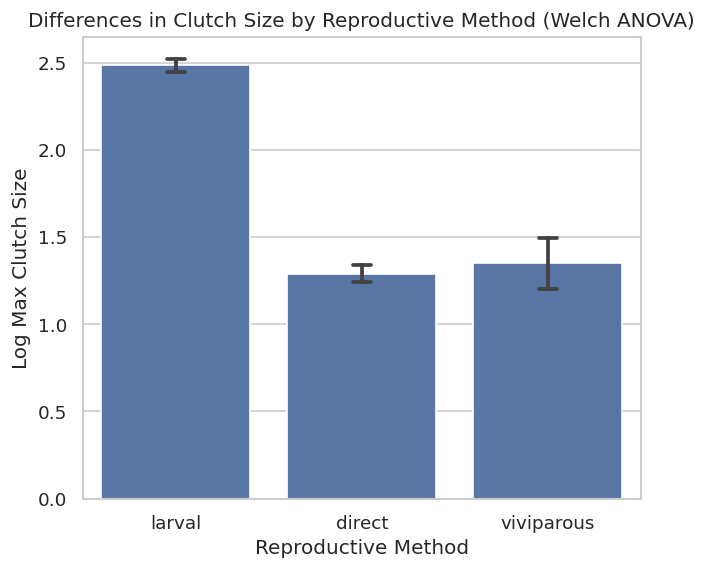

Saved: outputs/figures/fig_anova_clutchsize_by_reproductive_method.png


In [34]:
#Welch ANOVA bxplot

"""
Figure __. Mean (±95% confidence interval) log-transformed clutch size traits
across amphibian reproductive modes (direct, larval, viviparous). Group differences
were evaluated using Welch’s ANOVA to account for unequal variances. Effect sizes (η²)
are reported alongside test statistics. Significant differences indicate trait divergence
across reproductive strategies.

"""

plt.figure(figsize=(6,5))

sns.barplot(
    data=df,
    x=GROUP,
    y=Y_MAX,
    errorbar="se",
    capsize=0.1
)

plt.xlabel("Reproductive Method")
plt.ylabel("Log Max Clutch Size")
plt.title("Differences in Clutch Size by Reproductive Method (Welch ANOVA)")

plt.show()
savefig("fig_anova_clutchsize_by_reproductive_method.png")

In [31]:
#setup for graphs

FIGDIR = "outputs/figures"
os.makedirs(FIGDIR, exist_ok=True)

df = df.copy()

GROUP = "reproductiveMethod"
HAB   = "habitatClass"

def savefig(name, dpi=300):
    path = os.path.join(FIGDIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()
    print("Saved:", path)

X = "logBodyLengthMm"
Y_MIN = "logClutchSizeMinN"
Y_MAX = "logClutchSizeMaxN"

=== Simple OLS ===
                            OLS Regression Results                            
Dep. Variable:      logClutchSizeMaxN   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     84.01
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           1.29e-18
Time:                        21:56:43   Log-Likelihood:                -600.63
No. Observations:                 500   AIC:                             1205.
Df Residuals:                     498   BIC:                             1214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3

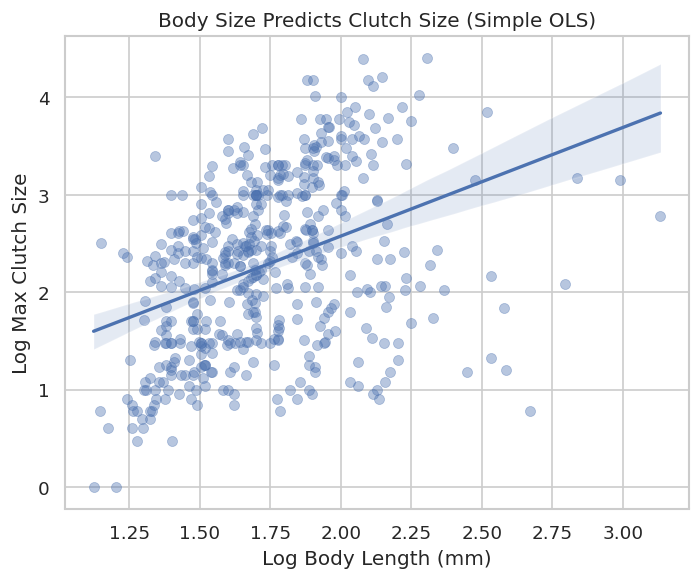

In [32]:
#OLS Regression Model
"""
Simple ordinary least squares (OLS) regression to evaluate the
baseline relationship between log10-transformed body length and log10-transformed
maximum clutch size across species. This model is univariate scale,
shows whether body size alone explains variation in
reproductive output prior to incorporating additional predictors

Outputs:
- OLS coefficient estimates, standard errors, t-statistics, and p-values
- Model R² as a measure of variance explained
- Regression line visual
"""

import statsmodels.formula.api as smf

# Freeze
df_simple = df[[
    "logBodyLengthMm",
    "logClutchSizeMaxN"
]].dropna().copy()

# Simple OLS
m_simple = smf.ols(
    "logClutchSizeMaxN ~ logBodyLengthMm",
    data=df_simple
).fit()

print("=== Simple OLS ===")
print(m_simple.summary())

print("\nR²:", m_simple.rsquared)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))

sns.scatterplot(
    data=df_simple,
    x="logBodyLengthMm",
    y="logClutchSizeMaxN",
    alpha=0.4,
    edgecolor=None
)

sns.regplot(
    data=df_simple,
    x="logBodyLengthMm",
    y="logClutchSizeMaxN",
    scatter=False,
    ci=95,
    line_kws={"linewidth":2}
)

plt.xlabel("Log Body Length (mm)")
plt.ylabel("Log Max Clutch Size")
plt.title("Body Size Predicts Clutch Size (Simple OLS)")

plt.tight_layout()
plt.show()

=== Multivariable OLS ===
                            OLS Regression Results                            
Dep. Variable:      logClutchSizeMaxN   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     103.6
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           4.56e-52
Time:                        22:08:30   Log-Likelihood:                -518.01
No. Observations:                 500   AIC:                             1044.
Df Residuals:                     496   BIC:                             1061.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

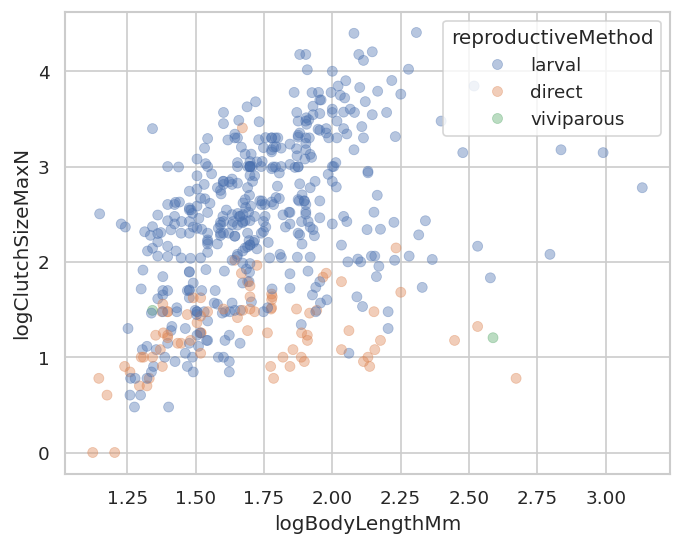

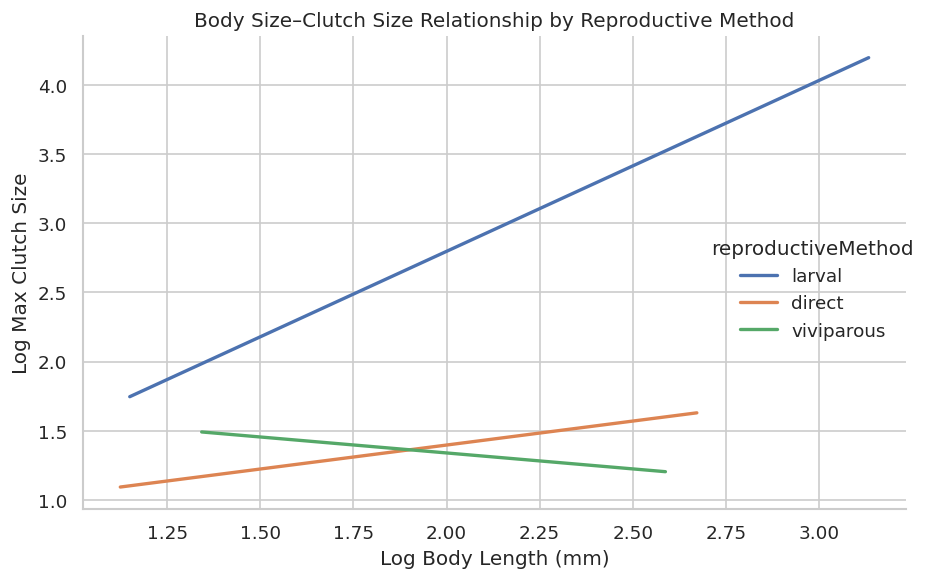

In [43]:
#Multivariable OLS
"""
Multivariable ordinary least squares (OLS) regression to show
if eproductive method explains variation in log10-transformed maximum clutch
size beyond the effect of body size. Log10-transformed body length isa
continuous predictor, reproductive method modeled as a categorical factor
with larval development treated as reference level.

Outputs:
- Multivariable OLS coefficient estimates, standard errors, t-statistics, and p-values
- Model R² and change in R² relative to the simple OLS model
- Stratified regression visual
"""
import statsmodels.formula.api as smf

# Freeze
df_multi = df[[
    "logBodyLengthMm",
    "logClutchSizeMaxN",
    "reproductiveMethod"
]].dropna().copy()

# Normalize category labels check
df_multi["reproductiveMethod"] = (
    df_multi["reproductiveMethod"]
    .astype("string")
    .str.strip()
    .str.lower()
)

df_multi["reproductiveMethod"] = pd.Categorical(
    df_multi["reproductiveMethod"],
    categories=["larval", "direct", "viviparous"],
    ordered=False
)

# Multivariable OLS
m_multi = smf.ols(
    "logClutchSizeMaxN ~ logBodyLengthMm + C(reproductiveMethod)",
    data=df_multi
).fit()

print("=== Multivariable OLS ===")
print(m_multi.summary())

print("\nR²:", m_multi.rsquared)

# ΔR² vs simple
print("ΔR² (vs simple):", m_multi.rsquared - m_simple.rsquared)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6.5,5))

sns.scatterplot(
    data=df_multi,
    x="logBodyLengthMm",
    y="logClutchSizeMaxN",
    hue="reproductiveMethod",
    alpha=0.4,
    edgecolor=None
)

sns.lmplot(
    data=df_multi,
    x="logBodyLengthMm",
    y="logClutchSizeMaxN",
    hue="reproductiveMethod",
    ci=None,
    height=5,
    aspect=1.2,
    scatter=False,
    line_kws={"linewidth": 2}
)

plt.xlabel("Log Body Length (mm)")
plt.ylabel("Log Max Clutch Size")
plt.title("Body Size–Clutch Size Relationship by Reproductive Method")

plt.tight_layout()
plt.show()

In [41]:
#HC3 Robust
"""
HC3 Robust re-estimates SE for the simple and multivariable ordinary
least squares (OLS) regression models using HC3 heteroskedasticity
estimate. Selected due to heteroskedasticity and
unequal variance in residuals, providing more inference without
altering coefficient. In addition, a joint Wald test is performed on the
categorical reproductive method in multivariable model to see
if contributes power beyond body size.

Outputs:
- OLS coefficient estimates with HC3 robust standard errors
- Robust t-statistics, p-values, and confidence intervals
- Joint Wald test statistic, degrees of freedom, and p-value
"""

import numpy as np

# HC3 robust covariance
m_simple_hc3 = m_simple.get_robustcov_results(cov_type="HC3")
m_multi_hc3  = m_multi.get_robustcov_results(cov_type="HC3")

print("Simple OLS (HC3 Robust SE)")
print(m_simple_hc3.summary())

print("\nMultivariable OLS (HC3 Robust SE)")
print(m_multi_hc3.summary())

import pandas as pd

def hc3_coef_table(model_hc3):
    names = model_hc3.model.exog_names
    ci = model_hc3.conf_int(alpha=0.05)

    return pd.DataFrame({
        "term": names,
        "beta": model_hc3.params,
        "robust_se_HC3": model_hc3.bse,
        "t": model_hc3.tvalues,
        "p": model_hc3.pvalues,
        "ci_low": ci[:, 0],
        "ci_high": ci[:, 1]
    })

tbl_simple_hc3 = hc3_coef_table(m_simple_hc3)
tbl_multi_hc3  = hc3_coef_table(m_multi_hc3)

display(tbl_simple_hc3)
display(tbl_multi_hc3)

# Robust joint Wald test
# By Intercept, logBodyLengthMm, C(reproductiveMethod)[T.direct], C(reproductiveMethod)[T.viviparous]

R = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

wald = m_multi_hc3.wald_test(R)

print("Robust Joint Wald Test (HC3)")
print(wald)

Simple OLS (HC3 Robust SE)
                            OLS Regression Results                            
Dep. Variable:      logClutchSizeMaxN   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     51.68
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           2.41e-12
Time:                        22:06:34   Log-Likelihood:                -600.63
No. Observations:                 500   AIC:                             1205.
Df Residuals:                     498   BIC:                             1214.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept      

,term,beta,robust_se_HC3,t,p,ci_low,ci_high
0,Intercept,0.346237,0.261969,1.321673,1.868839e-01,-0.168463,0.860938
1,logBodyLengthMm,1.114455,0.155031,7.188619,2.409820e-12,0.809861,1.419050


,term,beta,robust_se_HC3,t,p,ci_low,ci_high
0,Intercept,0.688105,0.227272,3.027674,2.592704e-03,0.241571,1.134640
1,C(reproductiveMethod)[T.direct],-1.137503,0.066621,-17.074354,9.397824e-52,-1.268397,-1.006610
2,C(reproductiveMethod)[T.viviparous],-1.360959,1.129634,-1.204779,2.288633e-01,-3.580417,0.858499
3,logBodyLengthMm,1.028257,0.131337,7.829131,2.997785e-14,0.770211,1.286304


Robust Joint Wald Test (HC3)
<F test: F=array([[31.12109681]]), p=1.8511278617604305e-13, df_denom=496, df_num=2>


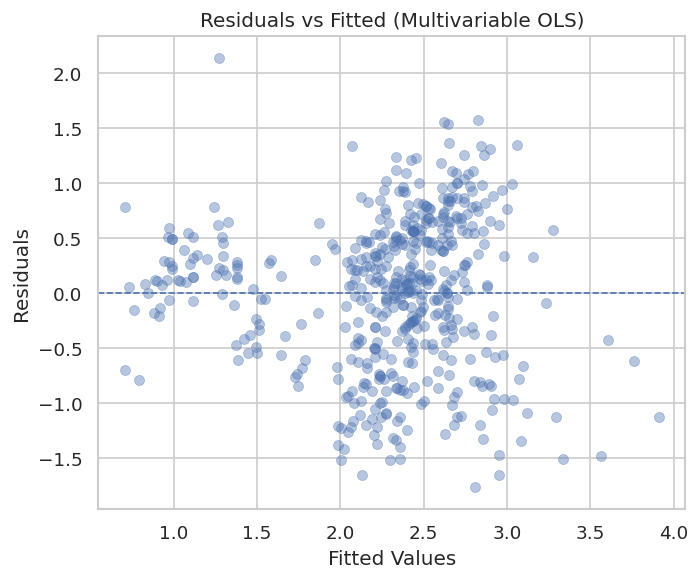

In [38]:
#OLS residual vs fit

import matplotlib.pyplot as plt
import seaborn as sns

# OLS residual geom
resid = m_multi.resid
fitted = m_multi.fittedvalues

plt.figure(figsize=(6,5))

sns.scatterplot(
    x=fitted,
    y=resid,
    alpha=0.4,
    edgecolor=None
)

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Multivariable OLS)")

plt.tight_layout()
plt.show()

Contingency table shape: (7, 3)


reproductiveMethod,direct,larval,viviparous
habitatClass,,,
aquatic-associated,35,131,1
aquatic-only,0,4,0
arboreal-only,4,12,0
generalist,22,168,1
other,1,5,0
terrestrial-associated,15,55,0
terrestrial-only,5,41,0


Chi-square = 10.6256
df = 12
p-value = 0.561249


reproductiveMethod,direct,larval,viviparous
habitatClass,,,
aquatic-associated,27.388,138.944,0.668
aquatic-only,0.656,3.328,0.016
arboreal-only,2.624,13.312,0.064
generalist,31.324,158.912,0.764
other,0.984,4.992,0.024
terrestrial-associated,11.480,58.240,0.280
terrestrial-only,7.544,38.272,0.184


Min expected count: 0.016
% of expected cells < 5: 57.1%
Cramér’s V = 0.1031


<Figure size 1200x720 with 0 Axes>

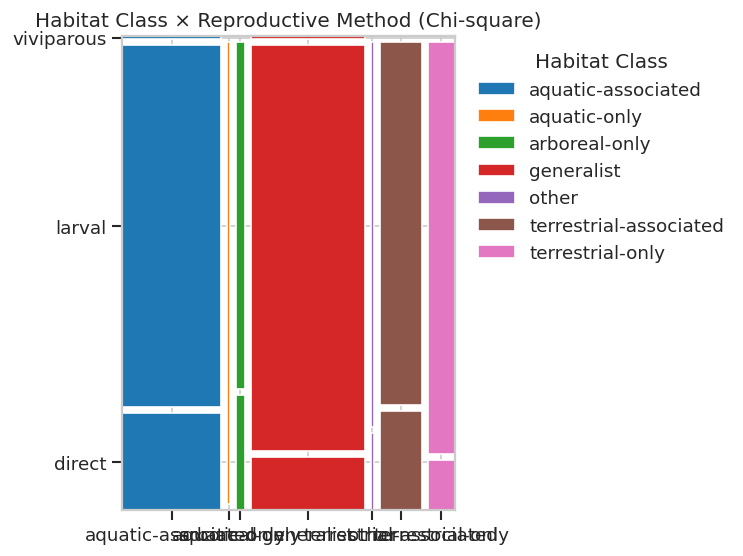

Saved: ./Outputs/fig_mosaic_habitat_x_reproductive_method.png


In [52]:
#Chi-square
"""
Evaluates association between categorical habitat class and
reproductive method using chi-square. A contingency table
of species counts, and the chi-square stat is used to
test the null hypothesis that habitat class and reproductive strategy are
independent
"""
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch

OUTDIR = "./Outputs"
os.makedirs(OUTDIR, exist_ok=True)

# var columns
HAB = "habitatClass"
GROUP = "reproductiveMethod"

# Contingency tables
ct = pd.crosstab(df[HAB].dropna(), df[GROUP].dropna())

print("Contingency table shape:", ct.shape)
display(ct)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct.values)

print(f"Chi-square = {chi2:.4f}")
print(f"df = {dof}")
print(f"p-value = {p:.6g}")

# Expected
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
display(expected_df)

min_expected = expected_df.values.min()
pct_lt5 = (expected_df.values < 5).mean() * 100
print(f"Min expected count: {min_expected:.3f}")
print(f"% of expected cells < 5: {pct_lt5:.1f}%")

# Effect size Cramér’s V
n = ct.values.sum()
r, k = ct.shape
cramers_v = np.sqrt((chi2 / n) / (min(r - 1, k - 1)))
print(f"Cramér’s V = {cramers_v:.4f}")

# Mosaic plot by dict keyed by (row, col)
count_dict = {(h, r_): int(ct.loc[h, r_]) for h in ct.index for r_ in ct.columns}

# Color habitat class (rows)
habitats = list(ct.index)
palette = sns.color_palette("tab10", n_colors=len(habitats))
hab_color = dict(zip(habitats, palette))

def props_func(key):
    h, r_ = key
    return {"facecolor": hab_color[h], "edgecolor": "white", "linewidth": 1}

# 6) Draw
plt.figure(figsize=(10, 6))
mosaic(
    count_dict,
    gap=0.02,
    labelizer=lambda k: "",
    properties=props_func
)

plt.title("Habitat Class × Reproductive Method (Chi-square)")
plt.xlabel("")  # mosaic axes label
plt.ylabel("")

# spacing
ax = plt.gca()
ax.set_xticks([])
ax.set_xticklabels([])

# Legend for habitat
handles = [Patch(facecolor=hab_color[h], edgecolor="white", label=str(h)) for h in habitats]
plt.legend(
    handles=handles,
    title="Habitat Class",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()

outpath = os.path.join(OUTDIR, "fig_mosaic_habitat_x_reproductive_method.png")
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", outpath)

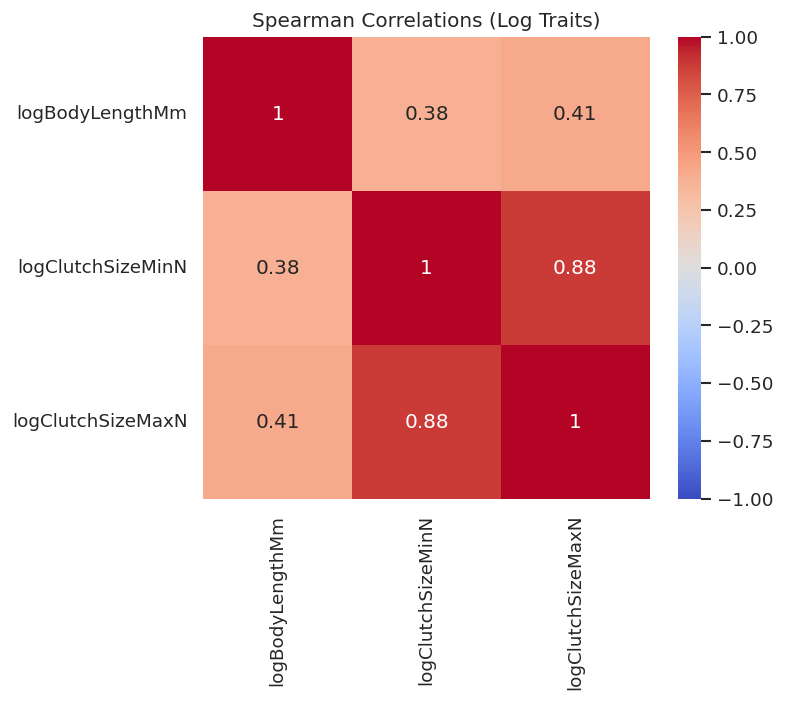

Saved: outputs/figures/fig_spearman_correlation_heatmap.png


In [53]:
#Spearman Corr

"""
Figure __. Spearman rank correlation heat map showing monotonic associations among
log-transformed amphibian life-history traits. Color intensity reflects the magnitude
and direction of Spearman’s ρ. This visualization summarizes nonparametric relationships
among traits and provides inferential context for subsequent regression analyses.

"""
plt.figure(figsize=(6,5))

sns.heatmap(
    df[[X, Y_MIN, Y_MAX]].corr(method="spearman"),
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)

plt.title("Spearman Correlations (Log Traits)")

plt.show()
savefig("fig_spearman_correlation_heatmap.png")

<Figure size 720x720 with 0 Axes>

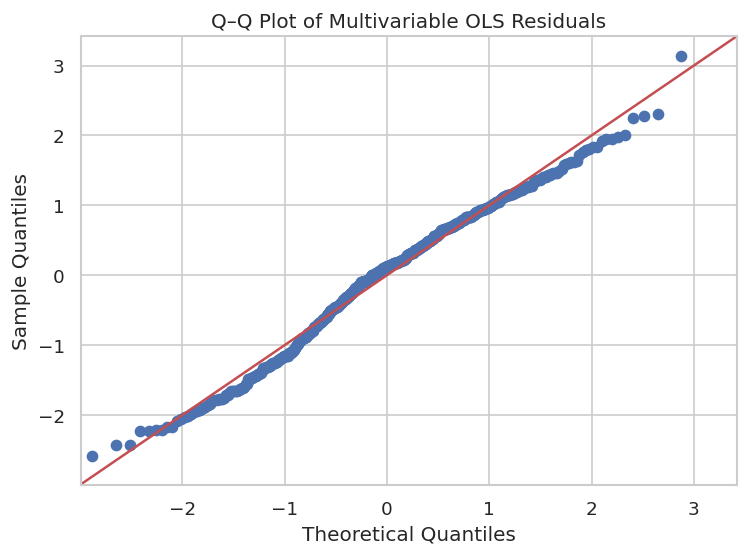

In [39]:
#Redo Q-Q for OLS (not the same as descrip)
import statsmodels.api as sm

plt.figure(figsize=(6,6))

sm.qqplot(
    resid,
    line="45",
    fit=True
)

plt.title("Q–Q Plot of Multivariable OLS Residuals")
plt.tight_layout()
plt.show()